## 스마트 센서 데이터를 통한 쾌적한 학습환경분석

### 개요 
![아두이노 설계](아두이노설계.png){: width="300"}
- 온도, 습도, 조도, 소음 등 환경 센서를 활용하여 각기 다른 장소에서 데이터를 수집하였고, 불쾌지수 계산 및 각 지표에 대한 정규화, 점수화 기법을 적용
- 여러 분석 기법을 활용하여 목적에 맞는 데이터 추출 

### 질문별 분석 매핑

|질문|분석 방법|
|---|---|
|장소별로 가장 쾌적한 환경은 어디인가? |점수 모델(정규화,가중치), 통계 분석, barplot|
|온도가 높으면 불쾌지수도 항상 높은가요?  조도와 소음, 온도 등 변수 간 관계는?|상관계수, 산점도, Heatmap|
|실내외 환경이 명확하게 구분되는가?|군집 분석(Kmean, PCA)|
|특정 장소의 소음 수치는 평소보다 이상한가요?|이상치 탐지(Z-score)|
|각 환경 변수의 중요도는?| 회귀계수 | 
|데이터 품질은 어떤가? (결측치, 이상치 등) | 결측치,이상치 분석 |

In [ ]:
### 라이브러리 설치
!pip install pandas matplotlib seaborn scikit-learn openpyxl

### 기초 통계자료 요약 

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import platform
from matplotlib import font_manager, rc

# 데이터 로드
df = pd.read_excel('environment_data_ko.xlsx')

# 분석에 사용할 feature들
features = ['celsius', 'humidity', 'heatindex', 'discomfort', 'cds', 'sound_dB']

# 기초 통계
stats_summary = df.groupby('location').describe()
print("기초 통계 요약:\n", stats_summary)

# 그래프 한글변환 오류함수
def set_graph_font():
    if platform.system() == 'Darwin':     # IOS
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Linux':
        path = "/usr/share/fonts/truetype/freefont/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('Unknown system... sorry~~~~') 

기초 통계 요약:
          celsius                                                          \
           count   mean           std   min     25%    50%     75%   max   
location                                                                   
강의실         10.0  24.70  3.744889e-15  24.7  24.700  24.70  24.700  24.7   
건물복도        10.0  20.35  5.270463e-02  20.3  20.300  20.35  20.400  20.4   
공원          10.0  23.47  3.888730e-01  22.9  23.150  23.50  23.775  24.0   
도서관         10.0  22.96  5.163978e-02  22.9  22.900  23.00  23.000  23.0   
독서실         10.0  27.40  0.000000e+00  27.4  27.400  27.40  27.400  27.4   
마켓          10.0  20.50  0.000000e+00  20.5  20.500  20.50  20.500  20.5   
야외          10.0  18.90  8.164966e-02  18.8  18.825  18.90  18.975  19.0   
정류장         10.0  19.71  3.162278e-02  19.7  19.700  19.70  19.700  19.8   
집           10.0  27.28  4.216370e-02  27.2  27.300  27.30  27.300  27.3   

         fahrenheit          ...   sound        sound_dB                   \

### 1. 장소별로 가장 쾌적한 환경은 어디인가? 
- 점수 모델(정규화, 가중치), 통계요약, barplot 
- 불쾌지수는 낮을수록 좋음
- 조도는 높을수록 좋음
- 소음은 낮을수록 좋음 

In [26]:
grouped = df.groupby("location").agg({
    "discomfort": "mean",
    "cds": "mean",
    "sound_dB": "mean"
}).reset_index()

# 점수 산출을 위해 각 항목 정규화 (0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

grouped['discomfort_score'] = 1 - scaler.fit_transform(grouped[['discomfort']])
grouped['cds_score'] = scaler.fit_transform(grouped[['cds']])
grouped['sound_score'] = 1 - scaler.fit_transform(grouped[['sound_dB']])
grouped['total_score'] = grouped[['discomfort_score', 'cds_score', 'sound_score']].mean(axis=1)

# 점수 순으로 정렬
grouped_sorted = grouped.sort_values(by='total_score', ascending=False)
grouped_sorted[['location', 'discomfort_score', 'cds_score', 'sound_score', 'total_score']]

print("** 장소별로 가장 쾌적한 환경은 '{}' 입니다.".format(grouped_sorted['location'].iloc[0]))
print("")
print(grouped_sorted)


** 장소별로 가장 쾌적한 환경은 '집' 입니다.

  location  discomfort    cds  sound_dB  discomfort_score  cds_score  \
8        집      78.366  411.4     7.803          0.000000   1.000000   
1     건물복도      69.705  239.1     8.035          0.824386   0.546579   
3      도서관      72.809  214.0     7.934          0.528936   0.480526   
0      강의실      74.470  202.7     7.882          0.370836   0.450789   
5       마켓      69.780  141.1     8.037          0.817247   0.288684   
4      독서실      76.470  127.3     7.812          0.180468   0.252368   
6       야외      67.860   44.2     8.165          1.000000   0.033684   
7      정류장      69.066   31.4     8.116          0.885208   0.000000   
2       공원      73.052   43.8     8.061          0.505806   0.032632   

   sound_score  total_score  
8     1.000000     0.666667  
1     0.359116     0.576694  
3     0.638122     0.549195  
0     0.781768     0.534464  
5     0.353591     0.486508  
4     0.975138     0.469325  
6     0.000000     0.344561  
7     0.13

#### 변수 중요도 기반 점수 조정 (가중치 조정)
- 뱡향성 조정 : 불쾌지수와 소음은 낮을수록 좋음 → 반전
- 불쾌지수 : 온도,습도를 종합적으로 반영한 대표적 지표로 0.4 가중치 
- 조도와 소음 : 환경적인 요소로 동등하게 분배 
- 가중치의 합이 1 이 되게끔 하여 분석

In [27]:
# 사용할 변수 선택
features_01 = ['discomfort', 'cds', 'sound_dB']
df_score = df[features_01 + ['location']].copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_score[features_01]), columns=features_01)
df_scaled['discomfort'] = 1 - df_scaled['discomfort']
df_scaled['sound_dB'] = 1 - df_scaled['sound_dB']

# 변수 가중치 설정
weights = {
    'discomfort': 0.4,
    'cds': 0.3,
    'sound_dB': 0.3
}

# 종합 점수 계산
df_scaled['score'] = (
    df_scaled['discomfort'] * weights['discomfort'] +
    df_scaled['cds'] * weights['cds'] +
    df_scaled['sound_dB'] * weights['sound_dB']
)
df_scaled['location'] = df_score['location']
location_scores = df_scaled.groupby('location')['score'].mean().sort_values(ascending=False)

print("** 장소별(가중치 조정)로 가장 쾌적한 환경은 '{}' 입니다.".format(location_scores.index[0]))
print("")
print(location_scores.head(10))

** 장소별(가중치 조정)로 가장 쾌적한 환경은 '건물복도' 입니다.

location
건물복도    0.609667
집       0.590538
도서관     0.549735
마켓      0.530352
강의실     0.517760
독서실     0.437509
야외      0.432239
정류장     0.413940
공원      0.315111
Name: score, dtype: float64


2. 측정 위치(location) 에 따라 섭씨 온도(celsius) 분포
- 가장 더운 공간: readingroom, house → 온도 관리 필요.
- 가장 쾌적한 공간: library, passage, market → 안정적인 학습 공간 가능성.
- 외부 환경 영향이 큰 공간: park, outdoor → 시간대나 날씨 고려 필요.

### 2. 환경 센서 데이터를 기준으로 변수 간의 상관관계를 시각화
- 온도가 높으면 불쾌지수도 항상 높은가요?  
- 조도와 소음, 온도 등 변수 간 관계는?


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/Users/armdiri/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


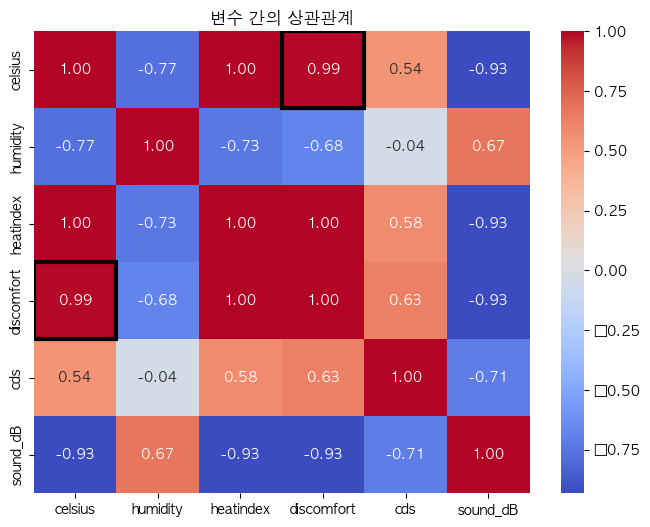

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

set_graph_font()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')

# 온도와 불쾌지수의 상관관계 (굵은 테두리)
i = features.index('celsius')
j = features.index('discomfort')
for (row, col) in [(i, j), (j, i)]:
    ax.add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='black', lw=3))

plt.title('변수 간의 상관관계')
plt.show()

### 3. 군집 분석 (Clustering)
- 실내외 환경이 명확하게 구분되는가? 군집 분석(K-mean, PCA)

- 위치별 환경 구분이 명확 : house, station, outdoor 등은 각각 매우 다른 환경 특성을 가짐. PCA로 잘 분리됨.  
- 실내 vs 실외 분리 가능 ( K-mean )  
   : 클러스터 수 측정방식 ( )

/Users/armdiri/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


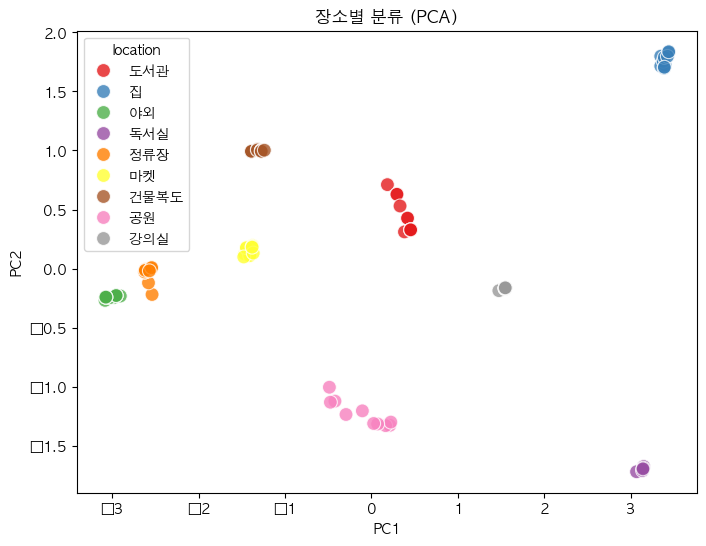

In [43]:
from sklearn.decomposition import PCA

set_graph_font()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['location'] = df['location']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='location', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('장소별 분류 (PCA)')
plt.show()

Elbow Method 최적의 K 값: 7
최적의 silhouette K 값: 9
최적의 davies_bouldin_score K 값: 9


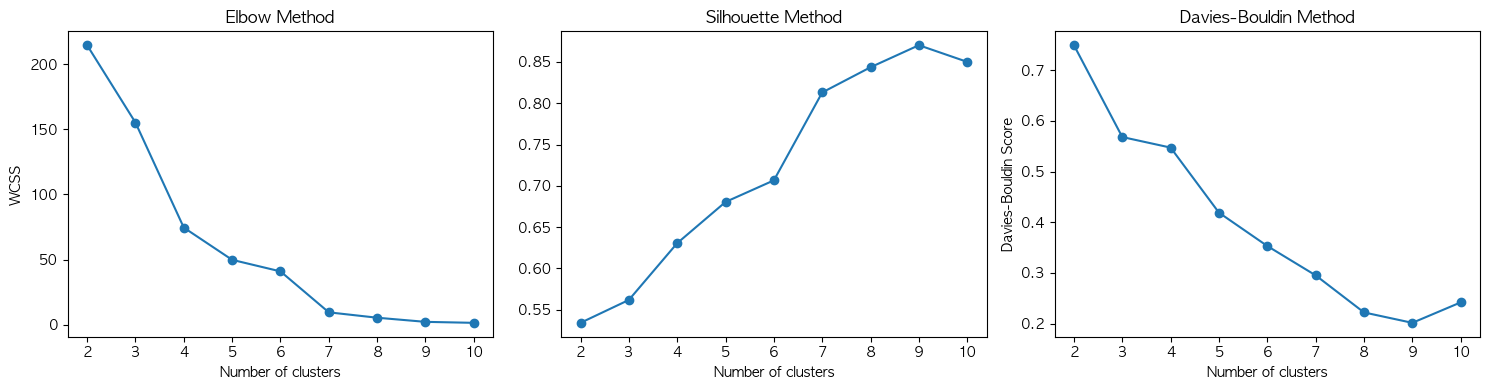

/Users/armdiri/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


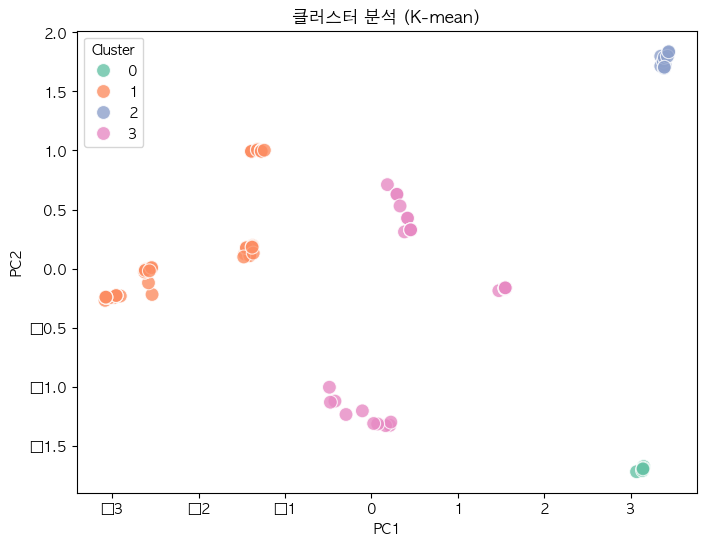

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator

# 군집의 범위 지정 
range_n_clusters = range(2, 11)
wcss = []
silhouette_scores = []
db_scores = []

# 5. 각 지표 계산 루프
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    db_scores.append(davies_bouldin_score(scaled_features, labels))

#print(wcss)
#print(silhouette_scores)
#print(db_scores)

## 최적의 K 값을 찾기 
kneedle = KneeLocator(range_n_clusters, wcss, curve="convex", direction="decreasing")
elbow_k = kneedle.elbow
print(f"Elbow Method 최적의 K 값: {elbow_k}")
silhouette_k = silhouette_scores.index(max(silhouette_scores))+2
print(f"최적의 silhouette K 값: {silhouette_k}")
db_k = db_scores.index(min(db_scores))+2
print(f"최적의 davies_bouldin_score K 값: {db_k}")

# 6. 시각화
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')

plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, db_scores, marker='o')
plt.title('Davies-Bouldin Method')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

## Elow Method 최적의 값을 보면 7 이지만 완만해 지는 시점인 4를 기준으로 K-mean 측정
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.8)
plt.title('클러스터 분석 (K-mean)')
plt.show()

### 결론 및 제언 (Conclusion & Future Work)

본 연구는 환경 센서 데이터를 기반으로 학습 장소의 쾌적도를 객관적으로 분석하였다. 정량적 기준을 적용함으로써 특정 장소에 대한 주관적 평가를 넘어서, 데이터 기반 추천이 가능함을 보여주었다.  
향후 연구에서는 시간대별 변화, 사람의 혼잡도, 개인 선호(예: 조용함을 선호하는 사람 vs 밝은 곳 선호하는 사람)를 반영한 맞춤형 쾌적도 모델 개발이 필요하다.

### 참고문헌 (예시)
- Lee, H., & Park, J. (2021). A Study on the Correlation between Discomfort Index and Concentration. Journal of Human-Centered Design.  
- Kim, S. et al. (2020). Environmental Data Analysis for Smart Learning Environments Using Arduino. Sensors and Systems.